In [1]:
import pickle
import pandas as pd

import requests
from bs4 import BeautifulSoup

import sys
import os

from collections import defaultdict
from collections import Counter

import re
import dateutil
from dateutil import parser

from __future__ import division
import datetime
from numpy import arange
import matplotlib.pyplot as plt
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.mpl_style = 'default'

In [2]:
with open('movie_info_revised.p' ,'r') as picklefile:
    movie_data = pickle.load(picklefile)

In [3]:
def parseint(string):
    '''
    Function to take a string and return only the digits from it
    '''
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [4]:
def date_helper(date):
    '''
    Function to confirm a data can be parsed into a datetime object. 
    '''
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [70]:
def make_genre_dictionary(movie_data, genre, condition, keyword):
    '''
    Function to extract movies by genre and keyword as a dictionary.
    
    The key 'count' gives the number of movies released matching the genre/keyword criteria for each year.
    
    Arguments: 
        movie_data: movie data scraped from imdb
        genre: find a list of them at: http://www.imdb.com/genre/
        condition: whether to filter items matching both keyword and genre or at least one of them.
                    enter 'and for both, and 'or' for at least one.
        keywords: find a list of them at: http://www.imdb.com/search/keyword/
    
    Returns:
        A dictionary with years and the number of movies released during that year
 
    '''
    genre_dict = defaultdict(dict)
    for key in movie_data.keys():
        ## if the condition is set to "and" and the matches must match both keywords:
        if condition == 'and':
        ## check to see if both conditions are present:
            if genre in movie_data[key]['genre'] and keyword in movie_data[key]['keywords']:
                if date_helper(movie_data[key]['date']):
                    year = parser.parse(movie_data[key]['date']).year
                    ## add the movie to the count for that year
                    genre_dict['count'][year]= genre_dict['count'].get(year, 0) + 1
        ## if condition is set to "or":
        else: 
            ## check to see if either one or both conditions are matched by keywords
            if genre in movie_data[key]['genre'] or keyword in movie_data[key]['keywords']:
                if date_helper(movie_data[key]['date']):
                    year = parser.parse(movie_data[key]['date']).year
                    ## add the movie to the count for that year
                    genre_dict['count'][year]= genre_dict['count'].get(year, 0) + 1 
    return genre_dict


In [6]:
def make_genre_data_frame(genre_dictionary, rolling_mean):
    '''
    Function that takes previously made genre dictionary and turns it into a pandas dataframe.
    
    Arguments:
        genre_dictionary: A dictionary of all movies matching a previously
        specified genre and keywords
        rolling_mean: how many years back you want the rolling mean to be based off of
    
    Returns:
        A pandas dataframe where the rolling mean column is the mean of the previous 5 years' counts, and the 
        diffrence from the mean column is how different the current year's mean is from 
        previous year's mean. 
    '''
    df = pd.DataFrame.from_dict(genre_dictionary)
    ## make the index of the dataframe consecutive years
    start = pd.datetime(1972, 1, 1)
    end = pd.datetime(2016, 1, 1)
    x = pd.date_range(start, end, freq='A').year
    df = df.reindex(x)
    df = df.fillna(0)
    ## make a column with the rolling mean of the n previous years
    df['rolling mean']=pd.rolling_mean(df['count'], rolling_mean).shift(+1)
    ## make a column that calculcated the proportion of the current year's movie count 
    ## and the rolling mean up to that point
    df['proportion of prior rolling mean']=df['count']/df['rolling mean']
    return df

In [92]:
## Find the movies that match your specified genre keywords 
## and make a count of how many of those matching movies were released each year
genre_dictionary = make_genre_dictionary(movie_data, 'distopia', 'or', 'post apocalypse')

In [72]:
## Make a dataframe that shows the yearly relaease counts and the rolling mean we want to use
df = make_genre_data_frame(genre_dictionary, 3)
df

,count,rolling mean,proportion of prior rolling mean
1972,5,NaN,NaN
1973,11,NaN,NaN
1974,11,NaN,NaN
1975,11,9.000000,1.222222
1976,9,11.000000,0.818182
1977,17,10.333333,1.645161
1978,14,12.333333,1.135135
1979,11,13.333333,0.825000
1980,9,14.000000,0.642857
1981,8,11.333333,0.705882


In [73]:
def plot_releases_and_rolling_mean(genre_dataframe):
    '''
    Function to plot the number of movies released each year as well as 
    the rolling mean.

    Arguments:
    df: a dataframe of movies released per year of the genre.

    Returns: a graph showing the movies released each year and the rolling mean for that year
    '''
    df_plot = genre_dataframe.reset_index()
    ## make a trend cutoff threshold that you want to use.   
    count = df_plot['count']
    rolling_mean = df_plot['rolling mean']
    difference_mean = df_plot['proportion of prior rolling mean']
    date = df_plot['index']
    figure(figsize=(15,8))
    count_line = plt.plot(date, count, label=count)
    rolling_mean_line = plt.plot(date,rolling_mean, label=rolling_mean)
    plt.legend(['Count','Rolling Mean'])
    plt.title('Dystopian Movies Released Per Year')
    plt.ylabel('Movies Made')
    plt.xlabel('Year')
    plt.savefig('rolling_mean', format='pdf')
    plt.show()



Populating the interactive namespace from numpy and matplotlib


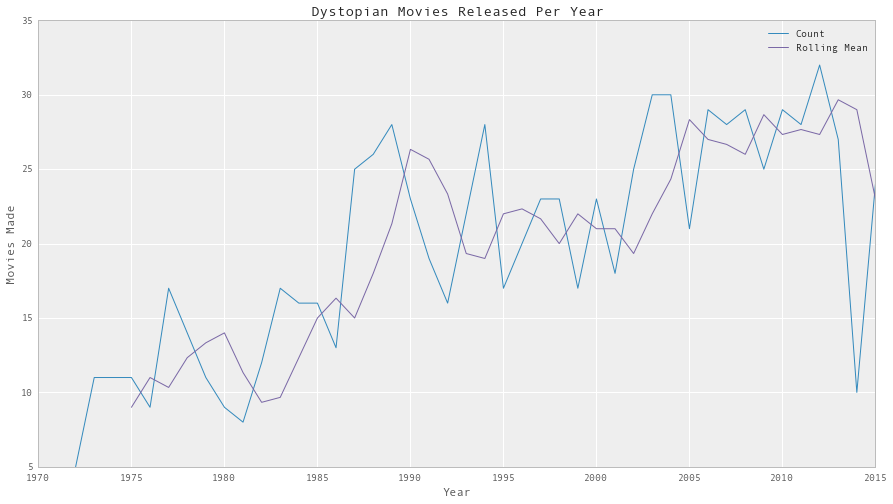

In [74]:
%pylab inline
plot_releases_and_rolling_mean(df)

In [75]:
def plot_trendiness(genre_dataframe, trend_proportion_threshold):
    '''
    Function to plot the difference between the movies released per year and the previous
    3 year mean. If year features many more movies of a trend released than in years prior, we
    can say it is "trending."
    The threshold argument allows you to determine what the cutoff is to define 'trending'

    Arguments:
    df: a dataframe of movies released per year of the genre. 
    trend_proportion_threshold: movies above this proportion threshold will be considered "trending"



    Returns: a graph showing the trendiness of a movie for each year
    '''
    df_plot = genre_dataframe.reset_index()
    df_plot['trend_cutoff'] = trend_proportion_threshold
    count = df_plot['count']
    rolling_mean = df_plot['rolling mean']
    difference_mean = df_plot['proportion of prior rolling mean']
    date = df_plot['index']
    cutoff = df_plot['trend_cutoff']
    figure(figsize=(15,8))
    count_line = plt.plot(date, cutoff, 'r-', label=count)
    rolling_mean_line = plt.plot(date, difference_mean, 'y-', label=count)
    plt.legend(['Trend Threshold ({})'.format(trend_proportion_threshold), 'Count as Proportion of Rolling Mean'])
    plt.title('Years Above Trend Threshold')
    plt.ylabel('Movies Made')
    plt.xlabel('Year')
    plt.savefig('trend_threshold', format='pdf')
    plt.show()

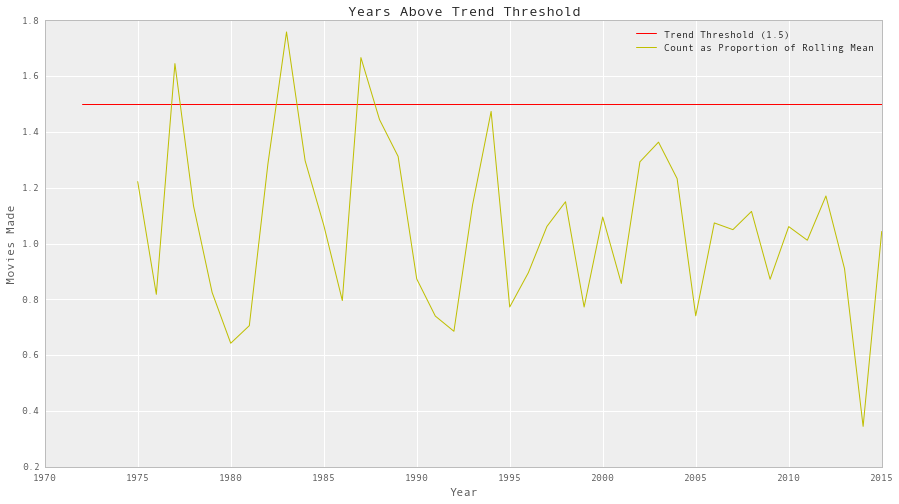

In [76]:
plot_trendiness(df, 1.5)

In [87]:
def make_genre_movie_info_dict(movie_data, genre, condition, keyword):
    '''
    Function to make a dictionary with only movies of a specific user-defined
    genre and keywords
    
    Arguments:
        movie_data: movie data scraped from imdb
        genre: find a list of them at: http://www.imdb.com/genre/
        keywords: find a list of them at: http://www.imdb.com/search/keyword/
    
    Returns:
        A dictionary with only movies of specific genre and keyword, and their 
        release data, and opening weekend screen numbers and box office intake. 
    '''
    movie_info_dict = defaultdict(dict)
    for key in movie_data.keys():
        if condition == 'and':
        ## check to see if both conditions are present:
            if genre in movie_data[key]['genre'] and keyword in movie_data[key]['keywords']:
                if date_helper(movie_data[key]['date']):
                    year = parser.parse(movie_data[key]['date']).year
                    movie_info_dict[year][key]= defaultdict(dict)
                    movie_info_dict[year][key]['date']= movie_data[key]['date']
                    movie_info_dict[year][key]['screens']= movie_data[key]['screens']
                    movie_info_dict[year][key]['opening']= movie_data[key]['opening']
        ## if condition is set to "or":
        else: 
            ## check to see if either one or both conditions are matched by keywords
            if genre in movie_data[key]['genre'] or keyword in movie_data[key]['keywords']:
                if date_helper(movie_data[key]['date']):
                    year = parser.parse(movie_data[key]['date']).year
                    movie_info_dict[year][key]= defaultdict(dict)
                    movie_info_dict[year][key]['date']= movie_data[key]['date']
                    movie_info_dict[year][key]['screens']= movie_data[key]['screens']
                    movie_info_dict[year][key]['opening']= movie_data[key]['opening']
    return movie_info_dict

In [93]:
movie_info_dict = make_genre_movie_info_dict(movie_data, 'distopia', 'or', 'post apocalypse')

In [94]:
def make_genre_df(genre_movie_info_dict, min_screens=0):
    '''
    Function to take a dictionary of movies and make a dataframe out of their info.
    
    Arguments:
        genre_movie_info_dict: a dictionary with movie_info 
        min_screens: allows you to filter out movies released on very few screens
    Returns:
        a pandas dataframe with all the movie info, and with movies with n/a's for
        screens released and opening intake filtered out.
        'normalized opening' column indicates the $ gross for the opening weekend per screen 
        upon which the movie was released that weekend. 
    
    '''
    frames = []
    years = []
    for year, movies in genre_movie_info_dict.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    ## filter out all movies that don't have the opening or screens data
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    ## create a normalized opeing column that calculates opening gross 
    ## per screen released. 
    genre['normalized_opening']= genre['opening']/genre['screens']
    ## filter out movies with outragous and erroneous gross 
    genre = genre[genre.normalized_opening < 20000]
    ## filter out movies released on very few screens. Those are either not such good
    ## indicators as being limited releases or simply bad data. 
    genre = genre[genre.screens > min_screens]
    genre = genre.reset_index()
    pd.set_option('display.max_rows', 1000)

    return genre

In [95]:
genre_df = make_genre_df(movie_info_dict, 50)

In [97]:
genre_df

,level_0,level_1,date,screens,opening,normalized_opening
0,1982,Mad Max 2: The Road Warrior,1982-05-21,704,2527864,3590.715909
1,1984,Night of the Comet,1984-11-16,1098,3580578,3261.000000
2,1984,Red Dawn,1984-08-10,1822,8230381,4517.223381
3,1984,The Terminator,1984-10-26,1005,4020663,4000.659701
4,1985,Day of the Dead,1985-07-19,168,1700000,10119.047619
5,1985,Mad Max Beyond Thunderdome,1985-07-10,1474,7283714,4941.461330
6,1986,Solarbabies,1986-11-26,692,704692,1018.341040
7,1990,Hardware,1990-09-14,695,2381285,3426.309353
8,1990,Robot Jox,1990-11-21,333,464441,1394.717718
9,1990,The Blood of Heroes,1990-02-23,318,471775,1483.569182


In [98]:
def plot_trend(genre_df, start_year, end_year):
    '''
    Takes a dataframe with all the movies of a trend and their box office stats
    and plots them in chronological order to see how the trend plays out over time.
    
    
    Arguments:
        trend_df: a dataframe with the trend info
        start_year: starting year of the trend
        end_year: ending year of the trend
    
    Returns: 
        a plot graphing the trend
    '''
    trend_df = genre_df[genre_df['level_0'].isin([i for i in range(start_year, end_year+ 1)])]
    figure(figsize=(17,13))
    trend_df = trend_df.sort(['date'])
    plt.plot(trend_df['date'], trend_df['normalized_opening'])
    plt.legend(["Opening Weekend $ per Screen Released"])
    return plt.show()
    

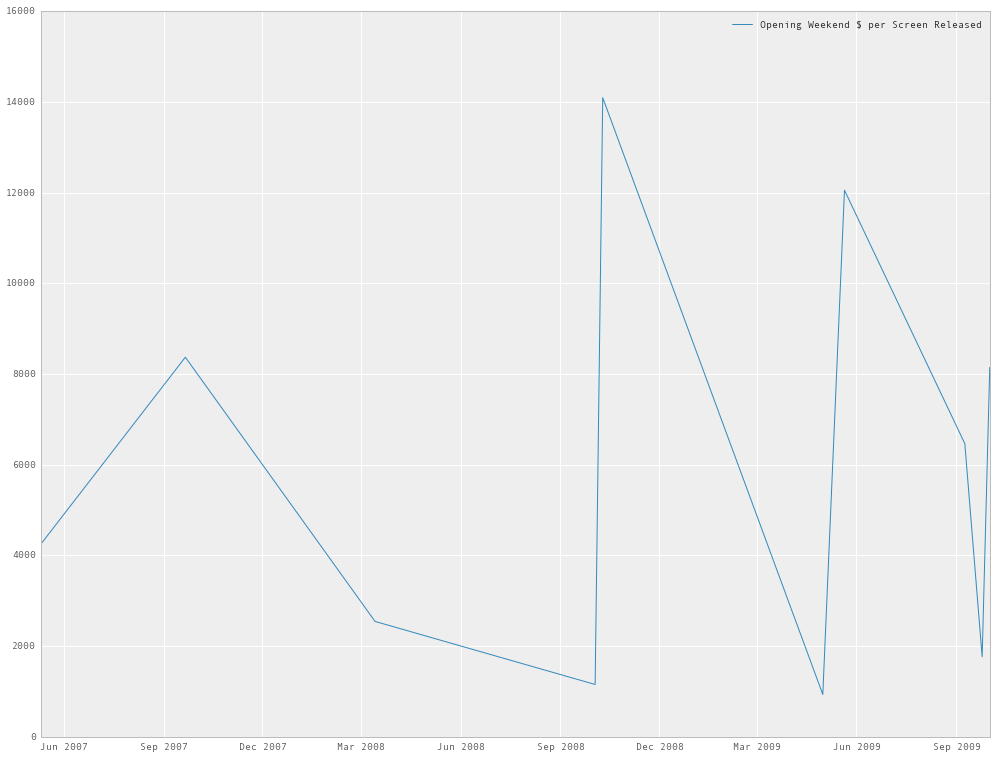

In [99]:
## plot trend
plot_trend(genre_df, 2007, 2009)


In [100]:
def sort_season(x):
    '''
    Adds a feature of season bins, to be used in the linear
    regressoin
    '''
    if x in [11, 12, 1]:
        return 'Winter'
    if x in [5, 6, 7, 8]:
        return 'Summer'
    if x in [9, 10,]:
        return 'Fall'
    if x in [2, 3, 4,]:
        return 'Spring'

In [101]:
def prepare_df_for_LR(trend_df, start_year, end_year):
    '''
    Takes the trend_df and adds the season feature, as well as adding 
    a time delta column, so we can plot the movie success against time 
    passed since movie trend began.
    Arguments: 
    trend_df: df of the movies belonging to the trend years
    start_year: year from which the progress of the trend will be plotted from
    
    '''
    ## make a dataframe with only movies in the trend years we want to explore:
    trend = genre_df[genre_df['level_0'].isin([i for i in range(start_year, end_year+ 1)])]
    start_year = '01/01/' + str(start_year)
    trend = trend.sort(['date'])
    ## time delta is time surpassed from the beginning of the year the trend started to the end of the trend
    trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse(str(start_year))))
    trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))
    ## indicate which season the movie was released in, so we can add that as a feature
    trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
    return trend
    
    

In [102]:
trend_df

,level_0,level_1,date,screens,opening,normalized_opening,time_delta,time_delta_num,season
135,2007,War,2007-08-24,2277,9820089,4312.731225,235 days 00:00:00,235,Summer
134,2007,American Gangster,2007-11-02,3054,43565115,14264.936149,305 days 00:00:00,305,Winter
137,2008,Pineapple Express,2008-08-06,3072,23245025,7566.739909,583 days 00:00:00,583,Summer
136,2008,Bangkok Dangerous,2008-09-05,2650,7783266,2937.081509,613 days 00:00:00,613,Fall
138,2008,Punisher: War Zone,2008-12-05,2508,4271451,1703.130383,704 days 00:00:00,704,Winter
141,2009,Street Fighter: The Legend of Chun-Li,2009-02-27,1136,4721110,4155.906690,788 days 00:00:00,788,Spring
140,2009,Public Enemies,2009-07-01,3334,25271675,7579.986503,912 days 00:00:00,912,Summer
139,2009,Ninja Assassin,2009-11-25,2503,13316158,5320.079105,1059 days 00:00:00,1059,Winter


In [103]:
trend_df = prepare_df_for_LR(genre_df, 2007, 2009)

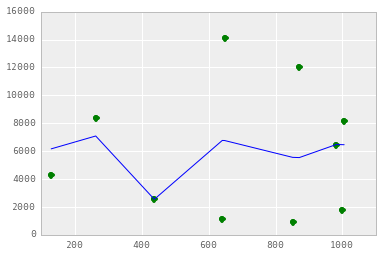

In [104]:

#plot the linear regression using trend_df dataframe
y, X = dmatrices('normalized_opening ~ time_delta_num + season ', data = trend_df, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plt.legend(["Opening Weekend $ per Screen Released"])
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')




In [127]:
## see results
model.fit().summary()

/Users/David/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     normalized_opening   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                 -0.147
Method:                 Least Squares   F-statistic:                    0.5515
Date:                Thu, 03 Dec 2015   Prob (F-statistic):              0.703
Time:                        22:59:55   Log-Likelihood:                -132.92
No. Observations:                  15   AIC:                             275.8
Df Residuals:                      10   BIC:                             279.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         4785.3274   1217.339      3.931      0.003      2072.927  7497.728
season[T.Spring] -1207.3727   1742.951     -0.693      0.504     -5090.909  2676.163
season[T.Summer]  -836.8577   1548.007     -0.541      0.601     -4286.032  2612.316
season[T.Winter]  1343.5206   1895.140      0.709      0.495     -2879.115  5566.156
time_delta_num      -0.6495      3.385     -0.192      0.852        -8.193     6.894
==============================================================================
Omnibus:                        3.717   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                1.776
Skew:                           0.539   Prob(JB):                        0.411
Kurtosis:                       1.704   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""